In [ ]:
from abc import ABCMeta, abstractmethod
from typing import Final

import numpy as np
import scipy.special
from matplotlib import pyplot as plt
from scipy.interpolate import PPoly

from fin_equation_analysis.fin.fin import Fin

In [ ]:
k: Final[int] = 5  # W m-1 K-1
h: Final[int] = 200  # W m-2 K-1
r: Final[float] = 3e-2  # m
L: Final[float] = 0.1  # m
T_b: Final[int] = 398  # K
T_inf: Final[int] = 298  # K

In [ ]:
class CircularPinFin(Fin, metaclass=ABCMeta):
    def __init__(
        self,
        k: int | float,
        h: int | float,
        r: int | float,
        L: int | float,
        Tb: int | float,
        Tinf: int | float,
    ) -> None:
        self.k = k
        self.h = h
        self.r0 = r
        self.L = L
        self.Tb = Tb
        self.Tinf = Tinf

    @abstractmethod
    def r(self, x: np.ndarray) -> np.ndarray:
        ...

    def P(self, x: np.ndarray) -> np.ndarray:
        return 2 * np.pi * self.r(x)

    def d2Ac_dx2(self, x: np.ndarray) -> np.ndarray:
        return np.zeros_like(x)

In [ ]:
class CircularUniformPinFin(CircularPinFin):
    def r(self, x: np.ndarray) -> np.ndarray:
        return self.r0

In [ ]:
class CircularLinearPinFin(CircularPinFin):
    def r(self, x: np.ndarray) -> np.ndarray:
        return self.r0 * (1 - x / self.L)

The general fin equation is given by

$$
\frac{d^2 \theta}{dx^2}
+ \left( \frac{1}{A_c} \frac{d A_c}{dx} \right) \frac{d \theta}{dx}
- \frac{h P}{k A_c} \theta
= 0
$$
where $\theta{(x)} \equiv T{(x)} - T_{\infty}$.

In state-space form,
\begin{gathered}
    \begin{align*}
        y_0 &= \theta{(x)} & y_1 &= \theta'{(x)} = \frac{d \theta}{dx} \\
        y_2 &= A_c{(x)} & y_3 &= A_c'{(x)} = \frac{d A_c}{dx}\\
    \end{align*}\\
    \begin{equation*}
        \frac{d \textbf{y}}{dx}
        = \begin{bmatrix} y'_0 \\ y'_1  \\ y'_2 \\ y'_3 \end{bmatrix}
        = \begin{bmatrix} \theta' \\ \theta'' \\ A'_c \\ A''_c \end{bmatrix}
        = \begin{bmatrix}
            y_1 \\
            - \frac{y_3}{y_2} y_1 + \frac{h P}{k y_2} y_0 \\
            y_3 \\
            \cdots
        \end{bmatrix}
    \end{equation*}
\end{gathered}

In [ ]:
def bc_uniform(ya, yb):
    return np.array(
        [
            ya[0] - (T_b - T_inf),  # y0(x=a) = T_b - T_inf
            yb[1],  # y1(x=b) = 0; adiabatic tip
            ya[2] - np.pi * r**2,  # y2(x=0) = np.pi * r**2
            yb[2] - np.pi * r**2,  # y2(x=b) = np.pi * r**2
        ]
    )

In [ ]:
def bc_linear(ya, yb):
    return np.array(
        [
            ya[0] - (T_b - T_inf),  # y0(x=a) = (T_b - T_inf)
            yb[1],  # y1(x=b) = 0; adiabatic tip
            ya[2] - np.pi * r**2,  # y2(x=0) = np.pi * r**2
            yb[2] - 1e-14,  # y2(x=b) = 0; reduces to a point
        ]
    )

In [ ]:
def plot_results(
    fig: plt.Figure,
    sol: tuple[PPoly, PPoly, PPoly, PPoly],
    x: np.ndarray,
    label: str,
) -> None:
    T, dT, Ac, dAc = sol
    axs = fig.axes
    axs[0].plot(x * 1e3, Ac * 1e6, label=label)
    axs[0].set_ylabel(r"$A_c{(x)}$ [mm$^2$]")

    axs[1].plot(x * 1e3, dAc * 1e3, label=label)
    axs[1].set_ylabel(r"$A'_c{(x)}$ [mm]")

    axs[2].plot(x * 1e3, T_inf + T, label=label)
    axs[2].set_ylabel(r"$T{(x)}$ [K]")

    axs[3].plot(x * 1e3, dT * 1e-3, label=label)
    axs[3].set_ylabel(r"$T'{(x)}$ [K / mm]")

    axs[4].plot(x * 1e3, -k * dT * 1e-6, label=label)
    axs[4].set_ylabel(r"$q''_x = -k T'{(x)}$ [W / mm$^2$]")

    axs[5].plot(x * 1e3, -k * Ac * dT, label=label)
    axs[5].set_ylabel(r"$q_x = -k A_c T'{(x)}$ [W]")

In [ ]:
x_plot = np.linspace(0, L, 100001)
sol_uniform = CircularUniformPinFin(k, h, r, L, T_b, T_inf).solve(bc_uniform)(x_plot)
sol_linear = CircularLinearPinFin(k, h, r, L, T_b, T_inf).solve(bc_linear)(x_plot)

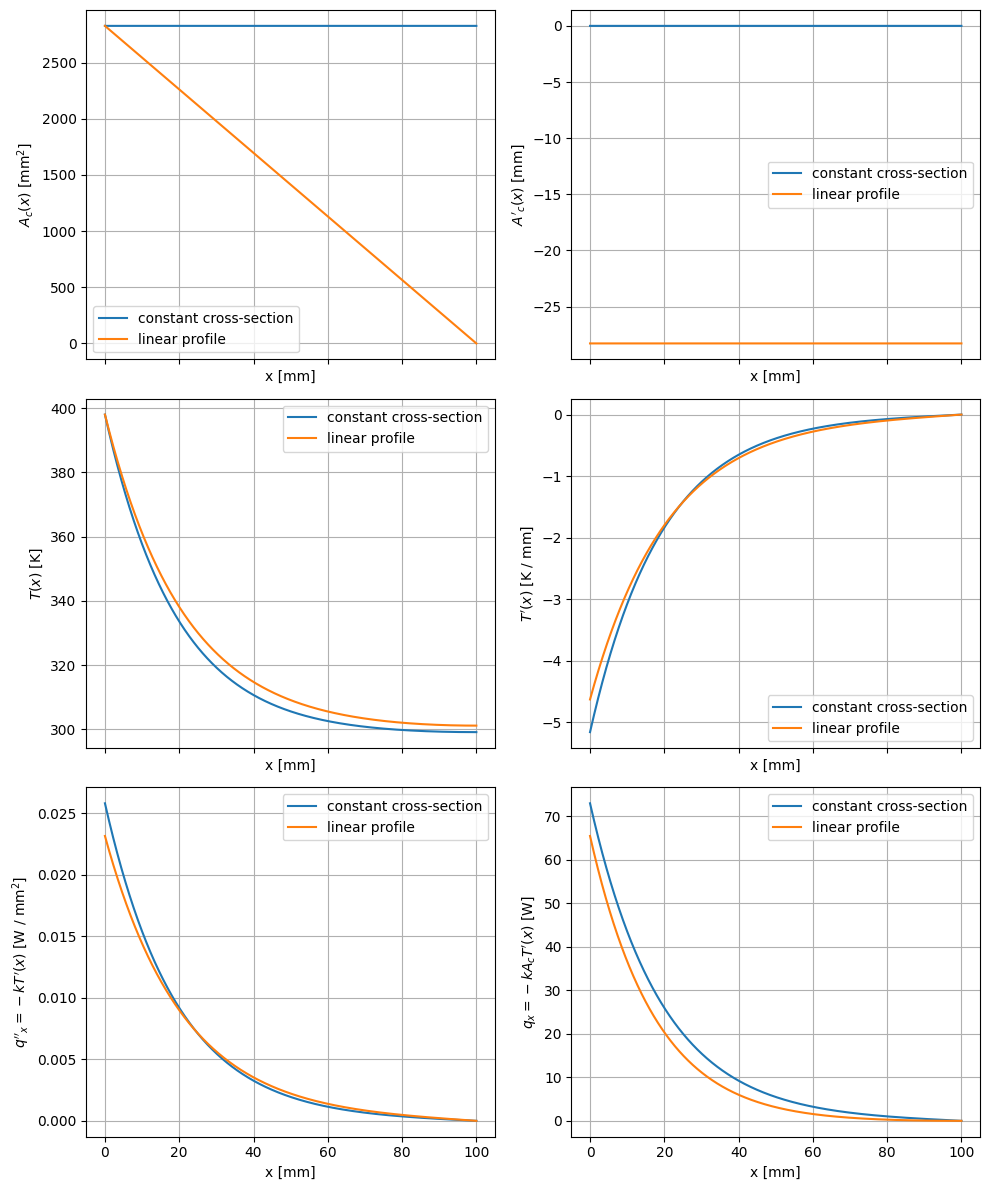

In [ ]:
fig, _ = plt.subplots(num=1, figsize=(10, 12), nrows=3, ncols=2, sharex="all")
plot_results(fig, sol_uniform, x_plot, "constant cross-section")
plot_results(fig, sol_linear, x_plot, "linear profile")

for ax in fig.axes:
    ax.set_xlabel(r"x [mm]")
    ax.grid(True)
    ax.legend()
plt.tight_layout()

In [ ]:
_, dT_uniform, Ac_uniform, _ = sol_uniform
_, dT_linear, Ac_linear, _ = sol_linear
q_uniform = (-k * Ac_uniform * dT_uniform)[5]
q_linear = (-k * Ac_linear * dT_linear)[5]
f"{q_uniform = }", f"{q_linear = }"

('q_uniform = 72.98039387924157', 'q_linear = 65.46953486574908')

In [ ]:
n_uniform = q_uniform / (h * 2 * np.pi * r * L * (T_b - T_inf))
n_linear = q_linear / (h * np.pi * r * np.sqrt(L**2 + r**2) * (T_b - T_inf))
f"{n_uniform = }", f"{n_linear = }"

('n_uniform = 0.19358650724458001', 'n_linear = 0.33267861395059317')

In [ ]:
M = np.sqrt(h * (2 * np.pi * r) * k * (np.pi * r**2)) * (T_b - T_inf)
m = np.sqrt((2 * h) / (k * r))
M, m, m * L

(73.00401616752501, 51.63977794943223, 5.163977794943223)

In [ ]:
q_uniform = M * np.tanh(m * L)
q_linear = (
    M
    * np.sqrt(1 + (r / L) ** 2)
    * scipy.special.iv(2, 2 * m * L)
    / scipy.special.iv(1, 2 * m * L)
)
f"{q_uniform = }", f"{q_linear = }"

('q_uniform = 72.99924100208747', 'q_linear = 65.4466121966634')

In [ ]:
n_uniform = np.tanh(m * L) / (m * L)
n_linear = 2 / (m * L) * scipy.special.iv(2, 2 * m * L) / scipy.special.iv(1, 2 * m * L)
f"{n_uniform = }", f"{n_linear = }"

('n_uniform = 0.1936365007906464', 'n_linear = 0.3325621340978629')